In [1]:
# Uninstall current PyTorch and related packages
!pip uninstall -y torch torchvision torchaudio

# Reinstall compatible version with CUDA 12.1
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install required packages
!pip install --no-deps pytorch-lightning==2.4.0
!pip install lightning-utilities torchmetrics
!pip install scikit-learn matplotlib

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import random
from collections import defaultdict
import pytorch_lightning as pl
import copy

# Verify torch version and GPU availability
print("Torch version:", torch.__version__)
# Check for GPU availability
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
    # Try moving a tensor to GPU
    print(torch.rand(2,2).cuda())
else:
    print("GPU is not available. To enable GPU, go to Runtime > Change runtime type > GPU.")

Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


# Split into labeled and unlabeled pools
def split_dataset(dataset, initial_labeled=10):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    labeled_indices = indices[:initial_labeled]
    unlabeled_indices = indices[initial_labeled:]
    return labeled_indices, unlabeled_indices

labeled_indices, unlabeled_indices = split_dataset(full_train_set, initial_labeled=10)

100%|██████████| 170M/170M [00:01<00:00, 86.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Clone the TypiClust repository
!git clone https://github.com/avihu111/TypiClust.git

import sys
# Add the path to the custom models directory
sys.path.append('/content/TypiClust/scan/models')

from google.colab import drive
import torch
import torch.nn as nn
import torchvision
from resnet_cifar import resnet18  # Import the custom ResNet from resnet_cifar.py

class SimCLR(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLR, self).__init__()
        # Use the custom ResNet for CIFAR-10 from the cloned repo.
        resnet_dict = resnet18(in_channel=3)
        self.backbone = resnet_dict['backbone']
        in_features = resnet_dict['dim']

        # Define the projection head separately
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim)
        )

    def forward(self, x):
        features = self.backbone(x)  # Extract features using the backbone
        proj = self.projection_head(features)  # Apply the projection head
        return proj

def load_pretrained_simclr_improved(model_path):
    """Enhanced version with better architecture matching and verification"""

    # 1. Initialize model with proper config
    model = SimCLR(feature_dim=128)


    # Print keys of the custom ResNet (model) state dictionary
    #print("Custom ResNet (SimCLR) state_dict keys:")
    #for key in model.state_dict().keys():
    #    print(key)
    #print("-----")


    # 2. Load checkpoint with safety checks
    try:
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
    except Exception as e:
        print(f"Warning: weights_only loading failed ({str(e)}), falling back")
        checkpoint = torch.load(model_path, map_location='cpu')

    # Print keys of the checkpoint
    #print("Checkpoint keys:")
    #for key in checkpoint.keys():
    #    print(key)
    #print("-----")

    adjusted_state_dict = {}
    for key, value in checkpoint.items():
      if key.startswith("contrastive_head."):
        new_key = key.replace("contrastive_head.", "projection_head.")
      else:
        new_key = key  # keep other keys (including backbone) unchanged
      adjusted_state_dict[new_key] = value

    missing_keys, unexpected_keys = model.load_state_dict(adjusted_state_dict, strict=False)
    print("Missing keys:", missing_keys)
    print("Unexpected keys:", unexpected_keys)
    return model

# ===== FeatureExtractor Class =====
class FeatureExtractor(nn.Module):
    """
    Wraps the SimCLR model to extract features from the penultimate layer (the backbone)
    and applies L2 normalization.
    """
    def __init__(self, simclr_model):
        super(FeatureExtractor, self).__init__()
        # We use the backbone of the SimCLR model.
        self.backbone = simclr_model.backbone

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)  # Flatten if needed
        x = F.normalize(x, p=2, dim=1)  # L2 normalization
        return x
# ========================================


# Mount Google Drive for accessing the pretrained weights
drive.mount('/content/drive')

# Load your checkpoint
checkpoint_path = "/content/drive/My Drive/cw2_ML/simclr_cifar-10.pth.tar"

simclr_model = load_pretrained_simclr_improved(checkpoint_path)
simclr_model = simclr_model.to('cuda')
simclr_model.eval()

# Create a feature extractor from the loaded SimCLR model
feature_extractor = FeatureExtractor(simclr_model).to('cuda')
feature_extractor.eval()





Cloning into 'TypiClust'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 814 (delta 133), reused 118 (delta 118), pack-reused 599 (from 1)
Receiving objects: 100% (814/814), 13.37 MiB | 35.73 MiB/s, done.
Resolving deltas: 100% (429/429), done.
Mounted at /content/drive
Missing keys: []
Unexpected keys: []


FeatureExtractor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [4]:
class TypiClust:
    def __init__(self, feature_extractor, dataset, max_clusters=500, k_neighbors=20):
        self.feature_extractor = feature_extractor  # Use the wrapper with L2 normalization
        self.dataset = dataset
        self.max_clusters = max_clusters
        self.k_neighbors = k_neighbors

    def extract_features(self, indices):
        """Extract features for given indices using the feature extractor"""
        features = []
        dataloader = DataLoader(Subset(self.dataset, indices), batch_size=256, shuffle=False)

        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to('cuda')
                feats = self.feature_extractor(images)
                features.append(feats.cpu())
        return torch.cat(features, dim=0).numpy()

    def select_queries(self, unlabeled_indices, budget, labeled_indices=None):
        """
        Select queries using TypiClust algorithm with covered/uncovered logic.
        This method clusters only the uncovered (unlabeled) indices,
                    selects the most typical sample per cluster, and marks neighbors as covered.

        Clustering on Uncovered Points:
        Instead of clustering the entire unlabeled set, we maintain an uncovered_mask that keeps track of which points have not yet been “covered” by a selected query.
        In each iteration, we cluster only on the uncovered points.
        """
        if labeled_indices is None:
            labeled_indices = []

        # Step 1: Extract features for unlabeled data
        unlabeled_features = self.extract_features(unlabeled_indices)
        num_unlabeled = len(unlabeled_indices)

        # Initialize a mask for uncovered points (True means uncovered)
        uncovered_mask = np.ones(num_unlabeled, dtype=bool)
        selected_queries = []

        # Continue until we have enough queries or no uncovered points remain
        while len(selected_queries) < budget and uncovered_mask.sum() > 0:
            # Cluster only on the uncovered features
            global_uncovered_indices = np.where(uncovered_mask)[0]
            uncovered_features = unlabeled_features[global_uncovered_indices]

            # Set number of clusters based on remaining budget and already labeled points
            num_clusters = max(1, len(labeled_indices) + (budget - len(selected_queries)))
            num_clusters = min(num_clusters, len(uncovered_features))  # cannot exceed available points
            print("num clusters is:", num_clusters)

            # Use KMeans or MiniBatchKMeans based on num_clusters
            if num_clusters <= 50:
                kmeans = KMeans(n_clusters=num_clusters, random_state=42)
            else:
                kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)

            cluster_labels = kmeans.fit_predict(uncovered_features)

            # Build clusters: mapping from cluster label to list of local indices (indices in uncovered_features)
            clusters = defaultdict(list)
            for local_idx, label in enumerate(cluster_labels):
                clusters[label].append(local_idx)

            # Fit a NearestNeighbors model on the uncovered_features
            nbrs = NearestNeighbors(n_neighbors=self.k_neighbors).fit(uncovered_features)

            # For each cluster, select the most typical sample
            for label, local_indices in clusters.items():
                if len(local_indices) == 0:
                    continue

                # Compute typicality (inverse average distance to k neighbors) for the cluster points
                distances, _ = nbrs.kneighbors(uncovered_features[local_indices])
                avg_distances = distances.mean(axis=1)
                typicalities = 1.0 / (avg_distances + 1e-8)

                # Select the index with the highest typicality
                best_local_idx = local_indices[np.argmax(typicalities)]
                # Map best_local_idx from uncovered_features back to the index in the full unlabeled_features array
                global_idx = global_uncovered_indices[best_local_idx]
                selected_queries.append(unlabeled_indices[global_idx])

                # Mark neighbors of this selected sample as covered
                distances_all, indices_all = nbrs.kneighbors(uncovered_features[best_local_idx:best_local_idx+1])
                neighbor_local_indices = indices_all[0]
                # Map these local indices back to global indices and mark them as covered
                global_neighbors = global_uncovered_indices[neighbor_local_indices]
                uncovered_mask[global_neighbors] = False

                if len(selected_queries) >= budget:
                    break

        return selected_queries




In [5]:
import matplotlib.pyplot as plt

def show_typiclust_results(dataset, selected_indices, num_images=30):
    """
    Displays a few images from 'selected_indices' to visualize
    which samples TypiClust chose.

    Args:
      dataset (torch.utils.data.Dataset): The dataset from which embeddings were generated.
      selected_indices (list or np.ndarray): Indices chosen by TypiClust.
      num_images (int): How many images to show (if fewer than len(selected_indices)).
    """
    nrows=5
    ncols=6
    plt.figure(figsize=(2*ncols, 2*nrows))

    # Show up to 'num_images' images
    max_images = min(num_images, len(selected_indices), nrows*ncols)

    for i in range(max_images):
        idx = selected_indices[i]
        # Retrieve the image and label from the dataset
        img, label = dataset[idx]

        if hasattr(img, 'permute'):
            img_np = img.permute(1, 2, 0).cpu().numpy()
        else:
            img_np = img

        # de-normalize
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])

        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img_np)
        plt.title(f"Index {idx}, Label {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



In [6]:
# --- New Helper Functions for Distribution and t-SNE ---

def show_label_distribution(dataset, indices, title=""):
    """
    Prints and plots a histogram of class distribution in the given 'indices'.
    """
    labels = [dataset[i][1] for i in indices]
    label_counts = np.bincount(labels, minlength=10)  # CIFAR-10 has 10 classes
    plt.bar(range(10), label_counts, color='blue', alpha=0.7)
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(range(10))
    plt.show()

def compute_tsne(feature_extractor, dataset, indices, n_samples=2000):
    """
    Extracts features for a subset of data and applies t-SNE for 2D visualization.
    - indices: indices to consider in the dataset (unlabeled + labeled).
    - n_samples: maximum number of samples for performance reasons.
    Returns the 2D t-SNE embeddings (shape [N,2]).
    """
    if len(indices) > n_samples:
        indices = random.sample(indices, n_samples)
    # Extract features
    feature_extractor.eval()
    loader = DataLoader(Subset(dataset, indices), batch_size=256, shuffle=False)
    all_feats = []
    all_idx = []
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(loader):
            images = images.to('cuda')
            feats = feature_extractor(images).cpu().numpy()
            all_feats.append(feats)
    all_feats = np.concatenate(all_feats, axis=0)
    # t-SNE
    print("Computing t-SNE on extracted features...")
    tsne = TSNE(n_components=2, init='pca', random_state=42)
    feats_2d = tsne.fit_transform(all_feats)
    return feats_2d, indices

def plot_tsne_colored(feats_2d, indices, labeled_indices_tc, labeled_indices_random):
    """
    Color each point based on whether it's in:
    - TypiClust-labeled
    - Random-labeled
    - Neither (still unlabeled)
    """
    labeled_tc_set = set(labeled_indices_tc)
    labeled_random_set = set(labeled_indices_random)

    colors = []
    for idx in indices:
        if idx in labeled_tc_set and idx in labeled_random_set:
            # (Edge case) If an index somehow ended in both sets
            colors.append("yellow")
        elif idx in labeled_tc_set:
            colors.append("blue")     # TypiClust-labeled
        elif idx in labeled_random_set:
            colors.append("green")    # Random-labeled
        else:
            colors.append("gray")     # Unlabeled

    plt.figure(figsize=(8,6))
    plt.scatter(feats_2d[:,0], feats_2d[:,1], c=colors, alpha=0.6, s=10)
    plt.title("t-SNE of CIFAR-10 features: Blue=TypiClust, Green=Random, Gray=Unlabeled")
    plt.axis("off")
    plt.show()

#. Run multiple trials and average the results
def active_learning_comparison_trials(dataset, initial_labeled=20, budget=20, rounds=5, trials=5):
    all_results = {
        'tc_supervised': [],
        'tc_linear': [],
        'tc_semi': [],
        'random_supervised': [],
        'random_linear': [],
        'random_semi': []
    }

    # Store final indices for one of the trials for visualization purposes.
    final_indices_storage = []

    # store results for each trial
    trial_results_list = []

    for trial in range(trials):
        print(f"\n=== Trial {trial+1}/{trials} ===")
        results, final_tc, final_random, final_unlab_tc, final_unlab_rand = active_learning_comparison(
            dataset, initial_labeled=initial_labeled, budget=budget, rounds=rounds)

        trial_results_list.append(results)  # store the results of this trial

        # plot each trial right after finishing it:
        plot_single_trial_results(results, trial+1, initial_labeled, budget, rounds)

        # Append trial results
        for key in all_results.keys():
            all_results[key].append(results[key])
        final_indices_storage.append((final_tc, final_random, final_unlab_tc, final_unlab_rand))

    # Compute average accuracy per round
    avg_results = {key: np.mean(all_results[key], axis=0) for key in all_results}
    std_results = {key: np.std(all_results[key], axis=0) for key in all_results}

    return avg_results, std_results, final_indices_storage

import matplotlib.pyplot as plt
import numpy as np

def plot_avg_results(avg_results, std_results, initial_labeled, budget, rounds):
    """
    Plots average accuracy curves with error bars for multiple AL methods
    across several rounds of active learning.
    """
    # x-axis: cumulative labeled set size at each round
    x_vals = np.arange(rounds) * budget + initial_labeled  # e.g., 20, 40, 60, 80, 100

    plt.figure(figsize=(8, 6))

    # Plot TypiClust Supervised
    plt.errorbar(
        x_vals,
        avg_results['tc_supervised'],
        yerr=std_results['tc_supervised'],
        fmt='o-',
        capsize=4,
        label='TypiClust (Supervised)'
    )

    # Plot Random Supervised
    plt.errorbar(
        x_vals,
        avg_results['random_supervised'],
        yerr=std_results['random_supervised'],
        fmt='o--',
        capsize=4,
        label='Random (Supervised)'
    )

    # Plot TypiClust Linear
    plt.errorbar(
        x_vals,
        avg_results['tc_linear'],
        yerr=std_results['tc_linear'],
        fmt='s-',
        capsize=4,
        label='TypiClust (Linear)'
    )

    # Plot Random Linear
    plt.errorbar(
        x_vals,
        avg_results['random_linear'],
        yerr=std_results['random_linear'],
        fmt='s--',
        capsize=4,
        label='Random (Linear)'
    )

    # If you have semi-supervised results, you can plot them similarly:
    plt.errorbar(
        x_vals,
        avg_results['tc_semi'],
        yerr=std_results['tc_semi'],
        fmt='^-',
        capsize=4,
        label='TypiClust (Semi-supervised)'
    )
    plt.errorbar(
        x_vals,
        avg_results['random_semi'],
        yerr=std_results['random_semi'],
        fmt='^--',
        capsize=4,
        label='Random (Semi-supervised)'
     )

    plt.xlabel('Number of Labeled Examples')
    plt.ylabel('Test Accuracy')
    plt.title('Active Learning Comparison (Average of Multiple Trials)')
    plt.xticks(x_vals)
    plt.ylim(0, 1)  # If your accuracies are in [0,1]. If in [0,100], change accordingly.
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_single_trial_results(results, trial_number, initial_labeled, budget, rounds):
    """
    Plots supervised, linear, and semi curves for TypiClust vs. Random
    for a single trial.
    """
    plt.figure(figsize=(8, 6))
    x_vals = np.arange(rounds) * budget + initial_labeled

    # Plot TypiClust
    plt.plot(x_vals, results['tc_supervised'], 'o-', label='TypiClust (Supervised)')
    plt.plot(x_vals, results['tc_linear'], 's-', label='TypiClust (Linear)')
    plt.plot(x_vals, results['tc_semi'], '^-', label='TypiClust (Semi)')

    # Plot Random
    plt.plot(x_vals, results['random_supervised'], 'o--', label='Random (Supervised)')
    plt.plot(x_vals, results['random_linear'], 's--', label='Random (Linear)')
    plt.plot(x_vals, results['random_semi'], '^--', label='Random (Semi)')

    plt.title(f"Active Learning Comparison - Trial {trial_number}")
    plt.xlabel('Number of Labeled Examples')
    plt.ylabel('Test Accuracy')
    plt.xticks(x_vals)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

class SupervisedModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SupervisedModel, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=False)
        # Modify first layer for CIFAR-10
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  # Remove initial maxpool
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)

def train_supervised(model, train_loader, test_loader, epochs=200):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.15,
        momentum=0.9,
        weight_decay=5e-4,
        nesterov=True
    )
    # Using cosine annealing scheduler over 'epochs' epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        scheduler.step()

    return evaluate_model(model, test_loader, device)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total   # return a fraction in [0, 1]


In [8]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def train_linear_on_features(model, feature_extractor, train_loader, test_loader, epochs=200):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=2.5, momentum=0.9)

    feature_extractor.eval()
    model.train()

    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            with torch.no_grad():
                features = feature_extractor(images)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            features = feature_extractor(images)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [9]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def train_semi_supervised(model, labeled_loader, unlabeled_loader, test_loader,
                          epochs=100, threshold=0.87):
    """
    Semi-supervised training with pseudo-labeling, confidence thresholding, and
    a sigmoid ramp-up for the unsupervised weight.

    Args:
        model (nn.Module): Your ResNet (or other) model.
        labeled_loader (DataLoader): DataLoader for the labeled subset.
        unlabeled_loader (DataLoader): DataLoader for the unlabeled subset.
        test_loader (DataLoader): DataLoader for the test set.
        epochs (int): Total training epochs. Default 200 (similar to snippet).
        threshold (float): Confidence threshold for pseudo-label acceptance. Default 0.95.

    Returns:
        float: Final accuracy (fraction in [0,1]) on the test set.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=2.5, momentum=0.9, nesterov=True)

    model.train()
    for ep in range(epochs):
        # 1) Compute unsup_weight via sigmoid ramp-up
        #    This grows from ~0 at the start to ~1 near the end.
        unsup_weight = float(1.0 / (1.0 + np.exp(-5*(ep/epochs - 0.5))))

        # We'll iterate over unlabeled_loader in parallel
        unl_iter = iter(unlabeled_loader)

        for inputs_l, labels_l in labeled_loader:
            # Supervised step
            inputs_l, labels_l = inputs_l.to(device), labels_l.to(device)
            sup_out = model(inputs_l)
            sup_loss = criterion(sup_out, labels_l)

            # Try to fetch a batch of unlabeled data in parallel
            try:
                inputs_u, _ = next(unl_iter)
            except StopIteration:
                # If we exhaust unlabeled_loader, re-initialize
                unl_iter = iter(unlabeled_loader)
                inputs_u, _ = next(unl_iter)

            inputs_u = inputs_u.to(device)
            with torch.no_grad():
                # Predict probabilities
                out_u = model(inputs_u)
                probs_u = torch.softmax(out_u, dim=1)
                max_probs, pseudo_labels = torch.max(probs_u, dim=1)

            # Mask out unlabeled samples below the threshold
            mask = (max_probs >= threshold).float()
            if mask.sum() > 0:
                out_u2 = model(inputs_u)
                unsup_loss = (criterion(out_u2, pseudo_labels) * mask).mean()
            else:
                unsup_loss = torch.tensor(0.0, device=device)

            total_loss = sup_loss + unsup_weight * unsup_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total  # returns fraction in [0,1]



=== Trial 1/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 19.10%
Linear accuracy: 24.24%
Semi-supervised accuracy: 10.33%

Random Sampling Results:
Supervised accuracy: 17.12%
Linear accuracy: 23.83%
Semi-supervised accuracy: 11.42%
num clusters is: 40

Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 22.71%
Linear accuracy: 31.40%
Semi-supervised accuracy: 10.03%

Random Sampling Results:
Supervised accuracy: 16.18%
Linear accuracy: 31.79%
Semi-supervised accuracy: 13.99%
num clusters is: 60

Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 22.31%
Linear accuracy: 34.05%
Semi-supervised accuracy: 9.84%

Random Sampling Results:
Supervised accuracy: 18.48%
Linear accuracy: 38.27%
Semi-supervised accuracy: 11.64%
num clusters is: 80

Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 9.81%
Linear accuracy: 40.06%
Semi-supervised accuracy: 11.21%

Random Sampling Results:
Supervised accuracy: 18.27%
Linear accuracy: 41.94%
Semi-supervised accuracy: 17.70%
num clusters is: 100

Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 22.65%
Linear accuracy: 41.61%
Semi-supervised accuracy: 12.87%

Random Sampling Results:
Supervised accuracy: 13.23%
Linear accuracy: 46.58%
Semi-supervised accuracy: 11.03%
num clusters is: 120


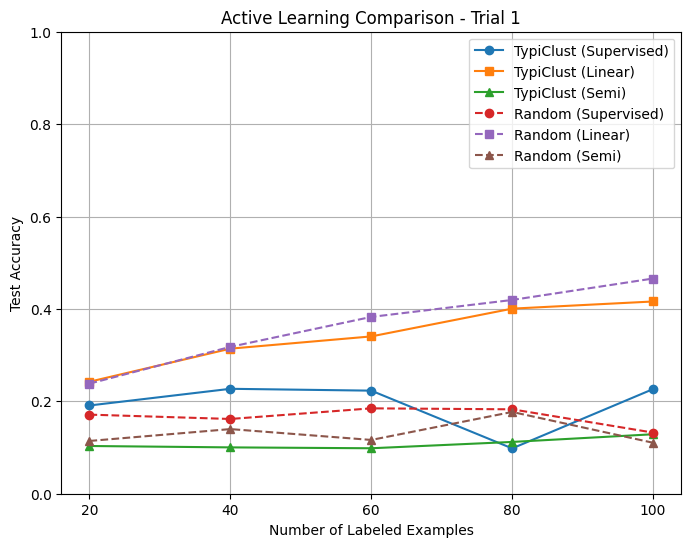


=== Trial 2/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 13.89%
Linear accuracy: 27.09%
Semi-supervised accuracy: 9.87%

Random Sampling Results:
Supervised accuracy: 11.58%
Linear accuracy: 28.71%
Semi-supervised accuracy: 10.05%
num clusters is: 40

Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 15.94%
Linear accuracy: 30.72%
Semi-supervised accuracy: 13.48%

Random Sampling Results:
Supervised accuracy: 19.30%
Linear accuracy: 33.25%
Semi-supervised accuracy: 9.47%
num clusters is: 60

Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 15.26%
Linear accuracy: 34.91%
Semi-supervised accuracy: 10.00%

Random Sampling Results:
Supervised accuracy: 17.89%
Linear accuracy: 36.02%
Semi-supervised accuracy: 10.00%
num clusters is: 80

Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 22.52%
Linear accuracy: 38.05%
Semi-supervised accuracy: 10.52%

Random Sampling Results:
Supervised accuracy: 15.49%
Linear accuracy: 41.51%
Semi-supervised accuracy: 10.00%
num clusters is: 100

Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 14.73%
Linear accuracy: 38.75%
Semi-supervised accuracy: 10.02%

Random Sampling Results:
Supervised accuracy: 17.60%
Linear accuracy: 44.80%
Semi-supervised accuracy: 14.07%
num clusters is: 120


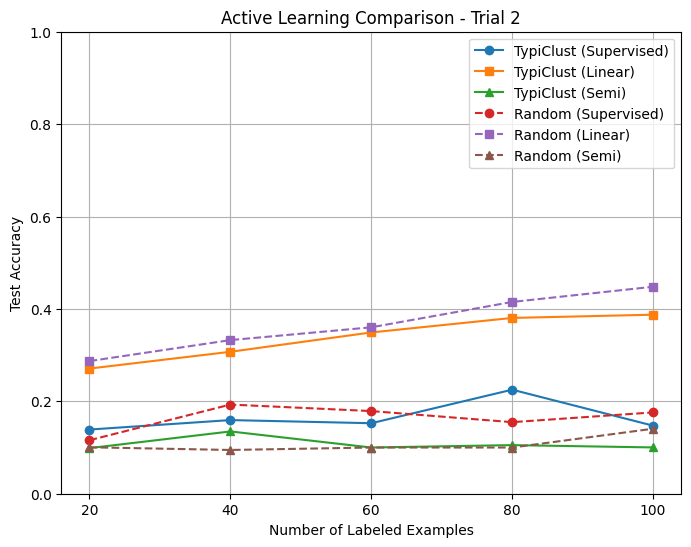


=== Trial 3/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 14.44%
Linear accuracy: 25.26%
Semi-supervised accuracy: 8.99%

Random Sampling Results:
Supervised accuracy: 14.73%
Linear accuracy: 25.04%
Semi-supervised accuracy: 7.80%
num clusters is: 40

Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 13.42%
Linear accuracy: 32.25%
Semi-supervised accuracy: 8.87%

Random Sampling Results:
Supervised accuracy: 15.61%
Linear accuracy: 30.76%
Semi-supervised accuracy: 10.04%
num clusters is: 60

Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 13.31%
Linear accuracy: 33.41%
Semi-supervised accuracy: 7.69%

Random Sampling Results:
Supervised accuracy: 9.03%
Linear accuracy: 36.15%
Semi-supervised accuracy: 10.38%
num clusters is: 80

Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 16.49%
Linear accuracy: 36.72%
Semi-supervised accuracy: 10.42%

Random Sampling Results:
Supervised accuracy: 10.49%
Linear accuracy: 40.76%
Semi-supervised accuracy: 10.09%
num clusters is: 100

Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 16.01%
Linear accuracy: 39.45%
Semi-supervised accuracy: 9.98%

Random Sampling Results:
Supervised accuracy: 9.93%
Linear accuracy: 44.05%
Semi-supervised accuracy: 10.05%
num clusters is: 120


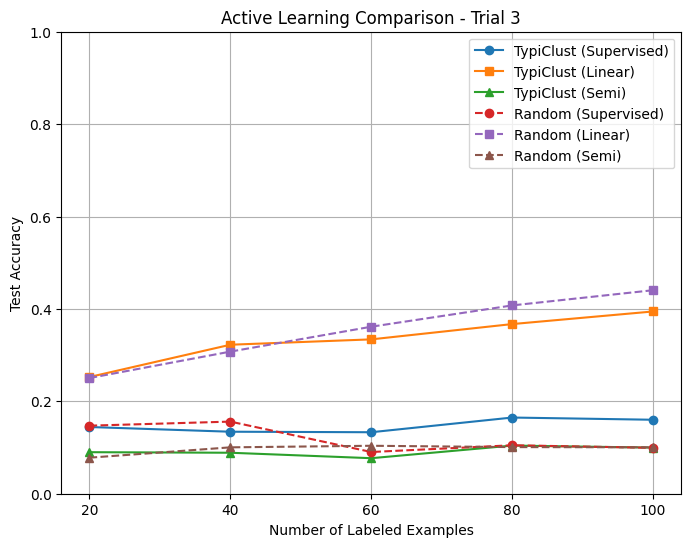


=== Trial 4/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 13.41%
Linear accuracy: 25.82%
Semi-supervised accuracy: 9.22%

Random Sampling Results:
Supervised accuracy: 15.27%
Linear accuracy: 25.92%
Semi-supervised accuracy: 11.16%
num clusters is: 40

Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 10.58%
Linear accuracy: 28.34%
Semi-supervised accuracy: 10.01%

Random Sampling Results:
Supervised accuracy: 15.22%
Linear accuracy: 30.53%
Semi-supervised accuracy: 10.05%
num clusters is: 60

Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 18.20%
Linear accuracy: 34.19%
Semi-supervised accuracy: 10.77%

Random Sampling Results:
Supervised accuracy: 9.05%
Linear accuracy: 36.66%
Semi-supervised accuracy: 10.18%
num clusters is: 80

Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 23.64%
Linear accuracy: 39.15%
Semi-supervised accuracy: 10.09%

Random Sampling Results:
Supervised accuracy: 20.65%
Linear accuracy: 38.42%
Semi-supervised accuracy: 9.99%
num clusters is: 100

Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 25.21%
Linear accuracy: 42.06%
Semi-supervised accuracy: 10.34%

Random Sampling Results:
Supervised accuracy: 10.13%
Linear accuracy: 40.35%
Semi-supervised accuracy: 10.12%
num clusters is: 120


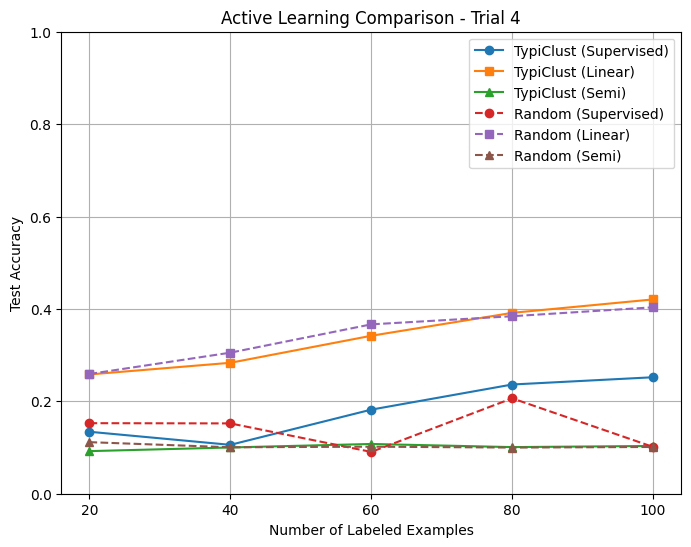


=== Trial 5/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 20.35%
Linear accuracy: 25.16%
Semi-supervised accuracy: 9.95%

Random Sampling Results:
Supervised accuracy: 19.30%
Linear accuracy: 23.66%
Semi-supervised accuracy: 9.54%
num clusters is: 40

Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 18.27%
Linear accuracy: 34.30%
Semi-supervised accuracy: 10.20%

Random Sampling Results:
Supervised accuracy: 18.13%
Linear accuracy: 37.62%
Semi-supervised accuracy: 10.79%
num clusters is: 60

Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 21.72%
Linear accuracy: 38.05%
Semi-supervised accuracy: 11.01%

Random Sampling Results:
Supervised accuracy: 23.93%
Linear accuracy: 42.34%
Semi-supervised accuracy: 10.02%
num clusters is: 80

Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 19.45%
Linear accuracy: 38.06%
Semi-supervised accuracy: 12.03%

Random Sampling Results:
Supervised accuracy: 20.02%
Linear accuracy: 44.38%
Semi-supervised accuracy: 10.00%
num clusters is: 100

Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 20.72%
Linear accuracy: 41.46%
Semi-supervised accuracy: 13.57%

Random Sampling Results:
Supervised accuracy: 19.21%
Linear accuracy: 47.73%
Semi-supervised accuracy: 10.07%
num clusters is: 120


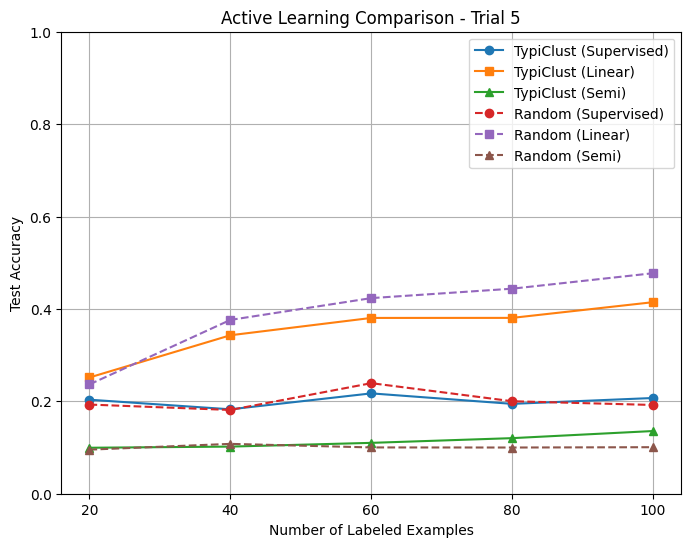

Final average test accuracy (TypiClust Supervised): 19.86%
Final average test accuracy (Random Supervised):   14.02%
Final average test accuracy (TypiClust Linear): 40.67%
Final average test accuracy (Random Linear):   44.70%
Final average test accuracy (TypiClust Semi): 11.36%
Final average test accuracy (Random Semi):   11.07%


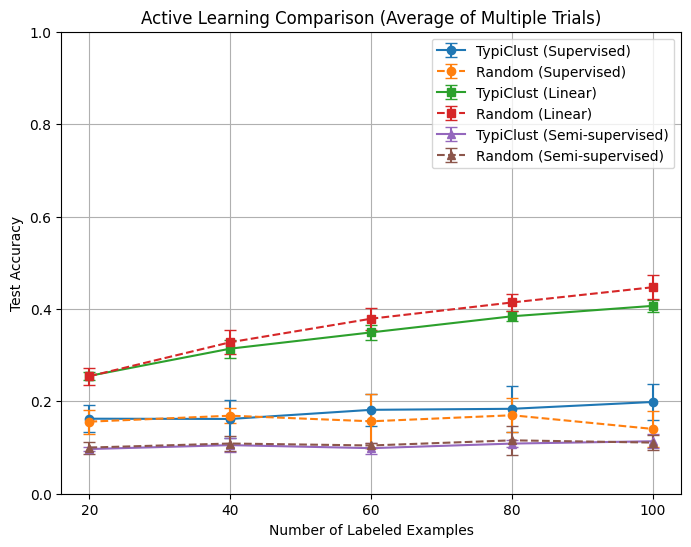

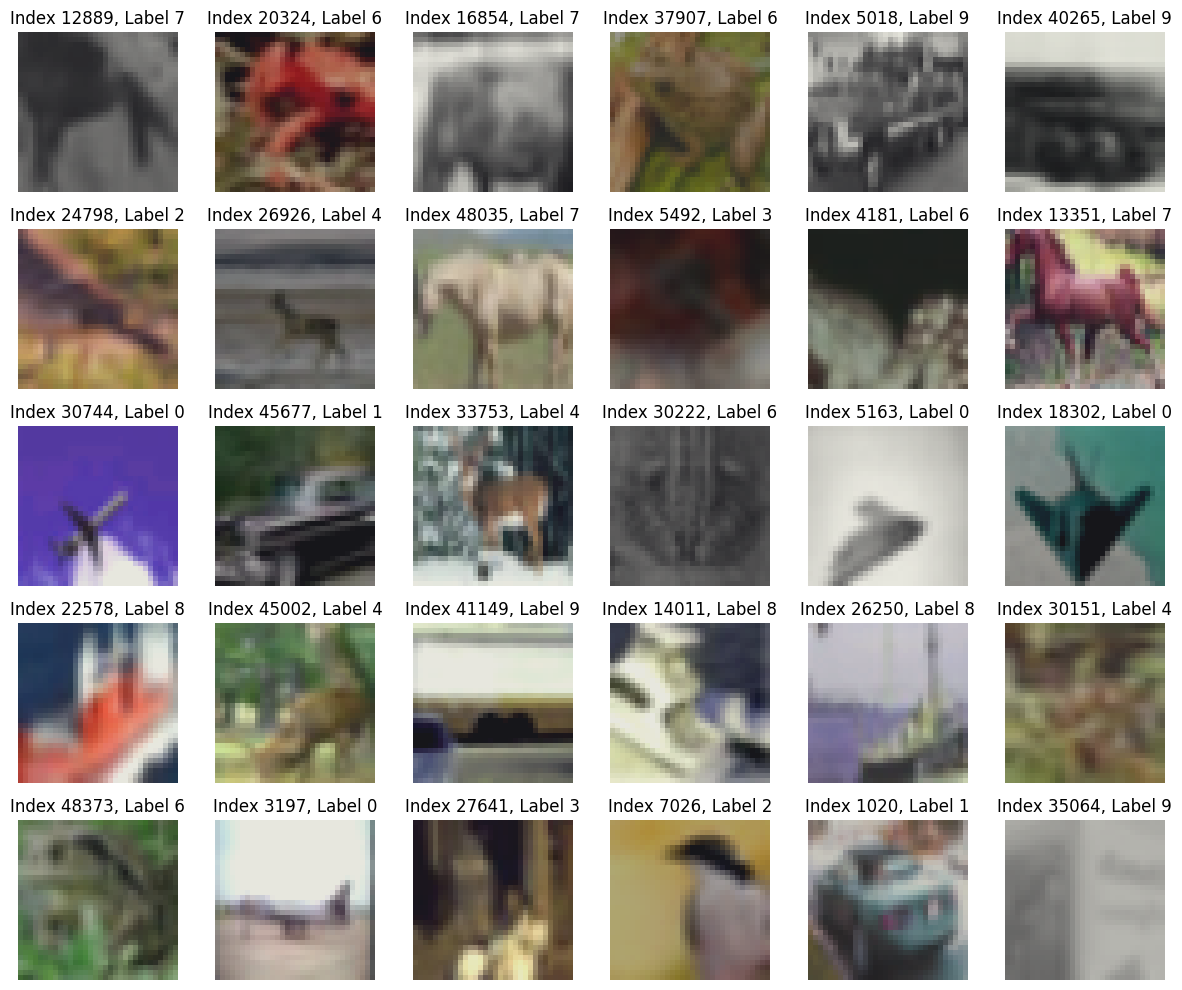


=== Label Distributions ===


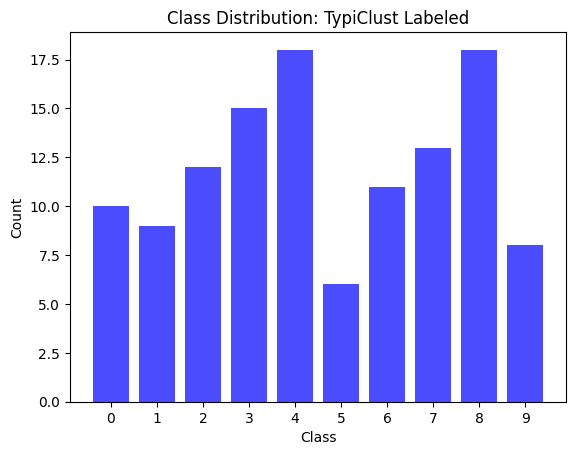

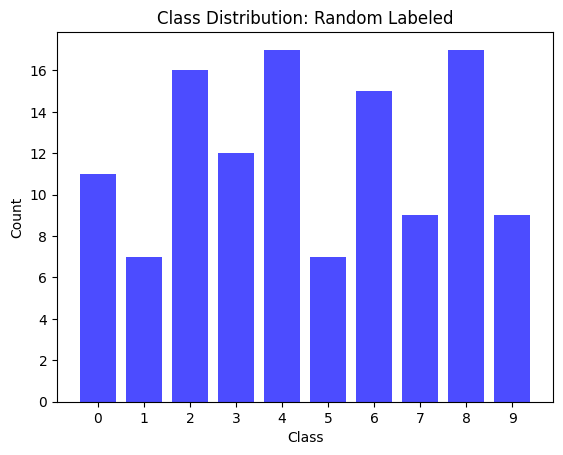

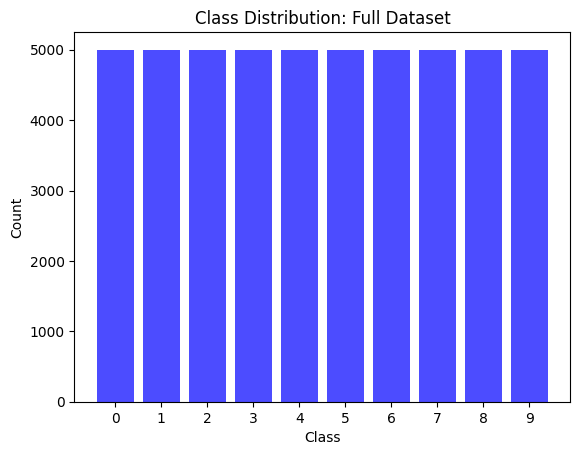

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


def active_learning_comparison(dataset, initial_labeled=20, budget=20, rounds=5):
    # Initialize device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize models with proper device placement
    typiclust = TypiClust(simclr_model.to(device), dataset)

    # Rest of your code remains the same, but add .to(device) to all models:
    model = SupervisedModel().to(device)
    linear_model = LinearClassifier().to(device)
    semi_model = SupervisedModel().to(device)

    # Initialize for TypiClust
    labeled_indices_tc, unlabeled_indices_tc = split_dataset(dataset, initial_labeled)
    labeled_indices_random = labeled_indices_tc.copy()
    unlabeled_indices_random = unlabeled_indices_tc.copy()

    # We'll store these final references so we can debug at the end
    final_labeled_tc = None
    final_labeled_random = None

    test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
    typiclust = TypiClust(simclr_model, dataset)

    # Results storage
    results = {
        'tc_supervised': [],
        'tc_linear': [],
        'tc_semi': [],
        'random_supervised': [],
        'random_linear': [],
        'random_semi': []
    }

    for round in range(rounds):
        print(f"\nRound {round+1}/{rounds}")
        print(f"Labeled pool size: {initial_labeled + budget*round}")

        # TypiClust evaluation
        print("\nTypiClust Results:")
        labeled_set_tc = Subset(dataset, labeled_indices_tc)
        labeled_loader_tc = DataLoader(labeled_set_tc, batch_size=256, shuffle=True)
        unlabeled_set_tc = Subset(dataset, unlabeled_indices_tc)
        unlabeled_loader_tc = DataLoader(unlabeled_set_tc, batch_size=256, shuffle=True)

        # Fully supervised
        model = SupervisedModel().to('cuda')
        acc = train_supervised(model, labeled_loader_tc, test_loader)
        results['tc_supervised'].append(acc)
        print(f"Supervised accuracy: {acc:.2%}")

        # Linear on features
        linear_model = LinearClassifier().to('cuda')
        acc = train_linear_on_features(linear_model, simclr_model, labeled_loader_tc, test_loader)
        results['tc_linear'].append(acc)
        print(f"Linear accuracy: {acc:.2%}")

        # Semi-supervised
        semi_model = SupervisedModel().to('cuda')
        acc = train_semi_supervised(semi_model, labeled_loader_tc, unlabeled_loader_tc, test_loader)
        results['tc_semi'].append(acc)
        print(f"Semi-supervised accuracy: {acc:.2%}")

        # Random sampling evaluation
        print("\nRandom Sampling Results:")
        labeled_set_random = Subset(dataset, labeled_indices_random)
        labeled_loader_random = DataLoader(labeled_set_random, batch_size=256, shuffle=True)
        unlabeled_set_random = Subset(dataset, unlabeled_indices_random)
        unlabeled_loader_random = DataLoader(unlabeled_set_random, batch_size=256, shuffle=True)

        # Fully supervised
        model = SupervisedModel().to('cuda')
        acc = train_supervised(model, labeled_loader_random, test_loader)
        results['random_supervised'].append(acc)
        print(f"Supervised accuracy: {acc:.2%}")

        # Linear on features
        linear_model = LinearClassifier().to('cuda')
        acc = train_linear_on_features(linear_model, simclr_model, labeled_loader_random, test_loader)
        results['random_linear'].append(acc)
        print(f"Linear accuracy: {acc:.2%}")

        # Semi-supervised
        semi_model = SupervisedModel().to('cuda')
        acc = train_semi_supervised(semi_model, labeled_loader_random, unlabeled_loader_random, test_loader)
        results['random_semi'].append(acc)
        print(f"Semi-supervised accuracy: {acc:.2%}")

        # Select new queries (TypiClust)
        queries_tc = typiclust.select_queries(unlabeled_indices_tc, budget, labeled_indices_tc)
        labeled_indices_tc.extend(queries_tc)
        unlabeled_indices_tc = [idx for idx in unlabeled_indices_tc if idx not in queries_tc]

        # Select random queries
        queries_random = random.sample(unlabeled_indices_random, budget)
        labeled_indices_random.extend(queries_random)
        unlabeled_indices_random = [idx for idx in unlabeled_indices_random if idx not in queries_random]

        # Store final references for distribution & t-SNE checks
        final_labeled_tc = labeled_indices_tc
        final_labeled_random = labeled_indices_random

    return results, final_labeled_tc, final_labeled_random, unlabeled_indices_tc, unlabeled_indices_random

def plot_comparison(results):
    plt.figure(figsize=(12, 8))
    x = np.arange(len(results['tc_supervised'])) * 20 + 20  # Starting from 20 labeled

    # Plot TypiClust results
    plt.plot(x, results['tc_supervised'], 'b-o', label='TypiClust (Supervised)')
    plt.plot(x, results['tc_linear'], 'g-o', label='TypiClust (Linear)')
    plt.plot(x, results['tc_semi'], 'r-o', label='TypiClust (Semi-supervised)')

    # Plot Random results
    plt.plot(x, results['random_supervised'], 'b--o', label='Random (Supervised)')
    plt.plot(x, results['random_linear'], 'g--o', label='Random (Linear)')
    plt.plot(x, results['random_semi'], 'r--o', label='Random (Semi-supervised)')

    plt.xlabel('Number of Labeled Examples')
    plt.ylabel('Test Accuracy')
    plt.title('Active Learning Comparison on CIFAR-10\n(20 Initial + 20 per Round × 5 Rounds)')
    plt.legend()
    plt.grid(True)
    plt.xticks(x)
    plt.ylim(0, 1)
    plt.show()

# --- RUN THE EXPERIMENT ---
initial_labeled=20
budget=20
rounds=5

labeled_indices, unlabeled_indices = split_dataset(full_train_set, initial_labeled=initial_labeled)

# Run multiple trials and average the results
avg_results, std_results, final_indices_storage = active_learning_comparison_trials(
    full_train_set, initial_labeled=initial_labeled, budget=budget, rounds=rounds, trials=5)


final_round_index = rounds - 1  # last round is index (rounds - 1)

# supervised
tc_supervised_final = avg_results['tc_supervised'][final_round_index]
random_supervised_final = avg_results['random_supervised'][final_round_index]

print(f"Final average test accuracy (TypiClust Supervised): {tc_supervised_final*100:.2f}%")
print(f"Final average test accuracy (Random Supervised):   {random_supervised_final*100:.2f}%")

# linear classifier
tc_linear_final = avg_results['tc_linear'][final_round_index]
random_linear_final = avg_results['random_linear'][final_round_index]

print(f"Final average test accuracy (TypiClust Linear): {tc_linear_final*100:.2f}%")
print(f"Final average test accuracy (Random Linear):   {random_linear_final*100:.2f}%")

# linear classifier
tc_semi_final = avg_results['tc_semi'][final_round_index]
random_semi_final = avg_results['random_semi'][final_round_index]

print(f"Final average test accuracy (TypiClust Semi): {tc_semi_final*100:.2f}%")
print(f"Final average test accuracy (Random Semi):   {random_semi_final*100:.2f}%")

# Plot the results like the paper.
plot_avg_results(avg_results, std_results, initial_labeled, budget, rounds)

# For t-SNE, we can use the final indices from one of the trials:
final_tc, final_random, final_unlab_tc, final_unlab_rand = final_indices_storage[0]
all_indices = final_tc + final_random + final_unlab_tc + final_unlab_rand


#show 30 images from the typiclust selection.
show_typiclust_results(full_train_set ,final_tc, 30)

# --- (1) Show Label Distribution for Final Labeled Sets ---
print("\n=== Label Distributions ===")
show_label_distribution(full_train_set, final_tc, "TypiClust Labeled")
show_label_distribution(full_train_set, final_random, "Random Labeled")
show_label_distribution(full_train_set, list(range(len(full_train_set))), "Full Dataset")


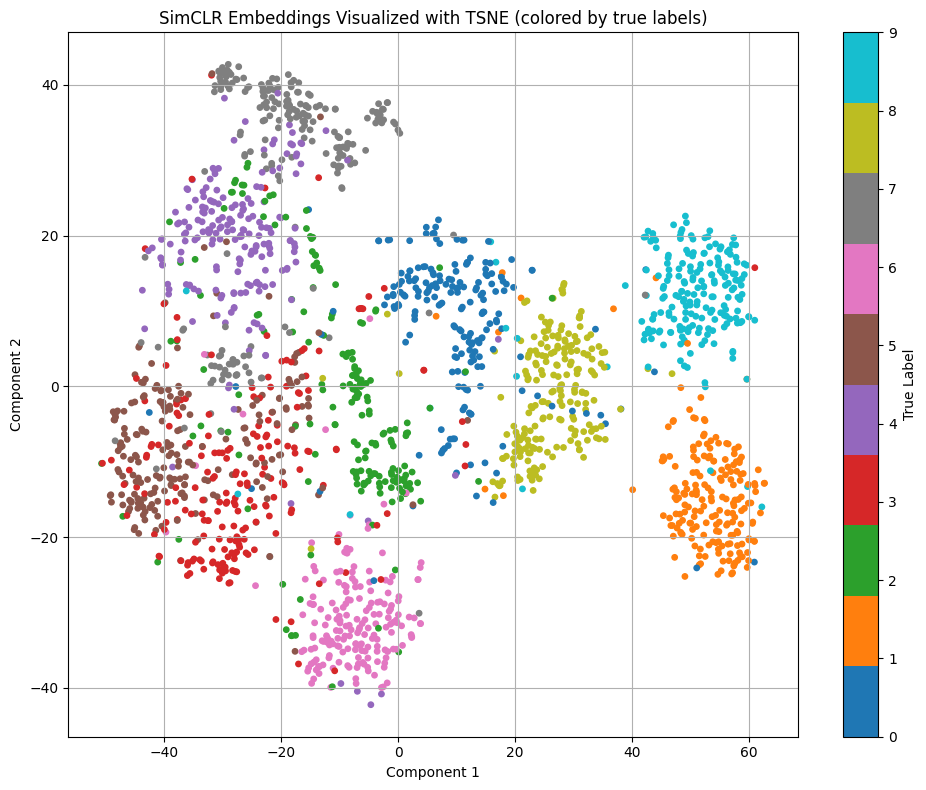

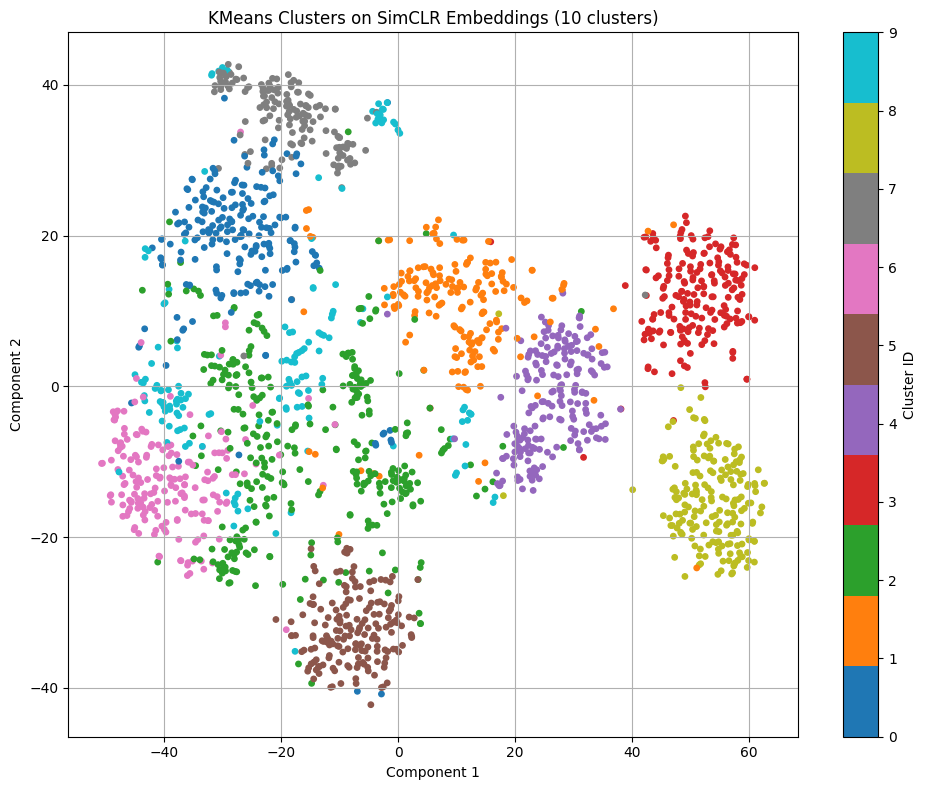

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def visualize_embedding_clusters(embeddings, labels, method='tsne', sample_size=2000, n_clusters=10):
    """
    Visualize clustering of embeddings using t-SNE or PCA.
    Args:
        embeddings (np.ndarray): Embeddings from SimCLR.
        labels (np.ndarray): True CIFAR-10 labels.
        method (str): 'tsne' or 'pca'
        sample_size (int): Number of samples to plot (for speed).
        n_clusters (int): Number of clusters to use in KMeans.
    """
    assert method in ['tsne', 'pca'], "method must be 'tsne' or 'pca'"

    # Subsample for faster plotting
    np.random.seed(42)
    indices = np.random.choice(len(embeddings), size=sample_size, replace=False)
    emb_subset = embeddings[indices]
    labels_subset = labels[indices]

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)

    reduced_embs = reducer.fit_transform(emb_subset)

    # KMeans on embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(emb_subset)

    # Plot clusters (color by true label)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=labels_subset, cmap='tab10', s=15)
    plt.title(f"SimCLR Embeddings Visualized with {method.upper()} (colored by true labels)")
    plt.colorbar(scatter, ticks=range(10), label='True Label')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Plot again with cluster ID coloring
    plt.figure(figsize=(10, 8))
    scatter2 = plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=cluster_ids, cmap='tab10', s=15)
    plt.title(f"KMeans Clusters on SimCLR Embeddings ({n_clusters} clusters)")
    plt.colorbar(scatter2, ticks=range(n_clusters), label='Cluster ID')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#debugging for visulazing the embeddings shape.
import numpy as np
from torch.utils.data import DataLoader

# Create a DataLoader for your dataset
loader = DataLoader(full_train_set, batch_size=256, shuffle=False)
all_embeddings = []
all_labels = []

# Generate embeddings for each image in the dataset
feature_extractor.eval()
with torch.no_grad():
    for images, labels in loader:
        images = images.to('cuda')
        feats = feature_extractor(images)
        all_embeddings.append(feats.cpu().numpy())
        all_labels.extend(labels.numpy())

# Concatenate all embeddings into a single numpy array
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.array(all_labels)

# Now visualize using your last method
visualize_embedding_clusters(all_embeddings, all_labels, method='tsne')
